Imports and Setup

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
from tensorflow.keras.regularizers import l2

In [2]:
import tensorflow as tf

In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
# Define the path to the dataset folder

dataset_folder = 'C:\\Users\\kavin\\Downloads\\CKD_Detection\\Dataset'
normal_kidneys_folder = os.path.join(dataset_folder, 'Normal')
ckd_kidneys_folder = os.path.join(dataset_folder, 'CKD')

# Define image size
image_size = (224, 224)

# Define batch size
batch_size = 32

# Define random seed for reproducibility
random_seed = 42

# Define ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,   # Apply random rotations (optional)
    width_shift_range=0.2,  # Apply random horizontal shifts (optional)
    height_shift_range=0.2,  # Apply random vertical shifts (optional)
    horizontal_flip=True,   # Apply random horizontal flips (optional)
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for the test data

Splitting Data and Class Labels

In [3]:
# Split the dataset into training (80%) and testing (20%) sets
normal_kidneys_folder = os.path.join(dataset_folder, 'Normal')
ckd_kidneys_folder = os.path.join(dataset_folder, 'CKD')

normal_kidneys_paths = [os.path.join(normal_kidneys_folder, filename) for filename in os.listdir(normal_kidneys_folder)]
ckd_kidneys_paths = [os.path.join(ckd_kidneys_folder, filename) for filename in os.listdir(ckd_kidneys_folder)]

# Split data
train_normal_data, test_normal_data = train_test_split(normal_kidneys_paths, test_size=0.2, random_state=random_seed)
train_ckd_data, test_ckd_data = train_test_split(ckd_kidneys_paths, test_size=0.2, random_state=random_seed)

# Combine training and testing data for both classes
train_data = train_normal_data + train_ckd_data
test_data = test_normal_data + test_ckd_data

# Define class labels
class_labels = ['Normal', 'CKD']
num_classes = len(class_labels)

In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

 Model Selection - Simple CNN

In [5]:
# Model 1: Simple Convolutional Neural Network (CNN)

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3), kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
], name='model1')

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Creating Data Generators

In [6]:
# Create data generators for training and validation
train_generator_normal = train_datagen.flow_from_directory(
    os.path.dirname(normal_kidneys_folder),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

train_generator_ckd = train_datagen.flow_from_directory(
    os.path.dirname(ckd_kidneys_folder),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

test_generator_normal = test_datagen.flow_from_directory(
    os.path.dirname(normal_kidneys_folder),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

test_generator_ckd = test_datagen.flow_from_directory(
    os.path.dirname(ckd_kidneys_folder),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 4887 images belonging to 2 classes.
Found 4887 images belonging to 2 classes.
Found 4887 images belonging to 2 classes.
Found 4887 images belonging to 2 classes.


Training the CNN Model

In [7]:
# Train the Simple CNN model
model1.fit(
  train_generator_normal, 
  steps_per_epoch=len(train_generator_normal),
  epochs=10,
  validation_data=train_generator_ckd,
  validation_steps=len(train_generator_ckd),
  callbacks=[reduce_lr]
)

Epoch 1/10
153/153 [==============================] - 411s 3s/step - loss: 1.0557 - accuracy: 0.8259 - val_loss: 0.5784 - val_accuracy: 0.9096 - lr: 0.0010
Epoch 2/10
 77/153 [==============>...............] - ETA: 2:32 - loss: 0.5220 - accuracy: 0.9087

KeyboardInterrupt: 

Model Selection - MobileNetV2 Transfer Learning

In [25]:
# Model 2: Transfer Learning with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(image_size[0], image_size[1], 3), include_top=False, weights='imagenet')
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model Training - MobileNetV2 Transfer Learning

In [26]:
# Create data generators for training and validation
train_generator_normal = train_datagen.flow_from_directory(
    os.path.dirname(normal_kidneys_folder),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

train_generator_ckd = train_datagen.flow_from_directory(
     os.path.dirname(ckd_kidneys_folder),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

# Train the MobileNetV2 Transfer Learning model
model2.fit(
    train_generator_normal,
    steps_per_epoch=len(train_generator_normal),
    epochs=10,  # Adjust as needed
    validation_data=train_generator_ckd,
    validation_steps=len(train_generator_ckd)
)


Found 4887 images belonging to 2 classes.
Found 4887 images belonging to 2 classes.
Epoch 1/10
153/153 [==============================] - 783s 5s/step - loss: 0.3599 - accuracy: 0.9720 - val_loss: 1.5678 - val_accuracy: 0.9560
Epoch 2/10
153/153 [==============================] - 760s 5s/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 7.8981 - val_accuracy: 0.8617
Epoch 3/10
153/153 [==============================] - 771s 5s/step - loss: 8.0414e-04 - accuracy: 0.9998 - val_loss: 0.5707 - val_accuracy: 0.9636
Epoch 4/10
153/153 [==============================] - 767s 5s/step - loss: 5.6801e-04 - accuracy: 0.9996 - val_loss: 0.0040 - val_accuracy: 0.9992
Epoch 5/10
153/153 [==============================] - 717s 5s/step - loss: 1.5435e-05 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9998
Epoch 6/10
153/153 [==============================] - 760s 5s/step - loss: 7.6197e-06 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9998
Epoch 7/10
153/153 [======================

Model Evaluation

In [39]:
# Evaluate the models on the test set
for model in [model1,model2]:
    test_generator_normal = test_datagen.flow_from_directory(
        os.path.dirname(normal_kidneys_folder),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )

    test_generator_ckd = test_datagen.flow_from_directory(
        os.path.dirname(ckd_kidneys_folder),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )

    normal_accuracy = model.evaluate(test_generator_normal, verbose=0)[1]
    ckd_accuracy = model.evaluate(test_generator_ckd, verbose=0)[1]

    print(f"Model '{model.name}' - Normal Kidney Accuracy: {normal_accuracy:.2f}, CKD Kidney Accuracy: {ckd_accuracy:.2f}")

Found 4887 images belonging to 2 classes.
Found 4887 images belonging to 2 classes.
Model 'model1' - Normal Kidney Accuracy: 0.03, CKD Kidney Accuracy: 0.03
Found 4887 images belonging to 2 classes.
Found 4887 images belonging to 2 classes.
Model 'model_1' - Normal Kidney Accuracy: 0.54, CKD Kidney Accuracy: 0.54


Preprocess the Uploaded Image

In [36]:
from PIL import Image
import numpy as np

# Load the uploaded image
uploaded_image = Image.open('C:\\Users\\kavin\\Downloads\\CKD_Detection\\Dataset\\Normal\\Normal-(2000).jpg')

# Resize the image to match the model's input size 
uploaded_image = uploaded_image.resize(image_size)

# Convert the image to a NumPy array and normalize pixel values
uploaded_image = np.array(uploaded_image) / 255.0


Get the Prediction

In [37]:
# Make predictions on the preprocessed image
predictions = model1.predict(np.expand_dims(uploaded_image, axis=0))

# Get the predicted class label
predicted_class = class_labels[np.argmax(predictions)]

1/1 [==============================] - 0s 50ms/step


Display the results

Predicted class: Normal
Confidence: 99.63%


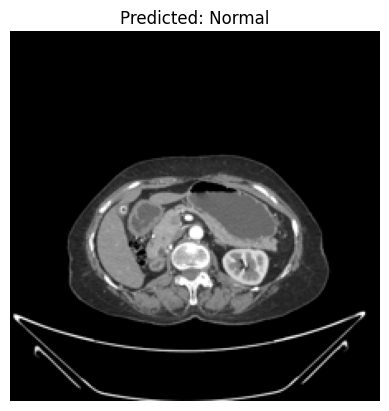

In [38]:
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {np.max(predictions) * 100:.2f}%")

# Display the uploaded image (optional)
import matplotlib.pyplot as plt

plt.imshow(uploaded_image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()